In [1]:
import numpy as np 
import pandas as pd 
import pathlib
import requests
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn import*
from sklearn import dummy, linear_model, feature_selection, metrics
from sklearn import model_selection, pipeline, preprocessing, impute, compose
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, brier_score_loss


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/predicting-diabetes/sample-submission.csv
/kaggle/input/predicting-diabetes/train.csv
/kaggle/input/predicting-diabetes/test.csv


In [2]:
data = pd.read_csv("/kaggle/input/predicting-diabetes/train.csv")

In [3]:
train_df1 = pd.read_csv("/kaggle/input/predicting-diabetes/train.csv")
features1 = train_df1.drop(["diabetes"], axis=1)
target1 = train_df1.loc[:, "diabetes"]

In [4]:
features = data.drop("diabetes", axis=1)
target = data.loc[:, "diabetes"]

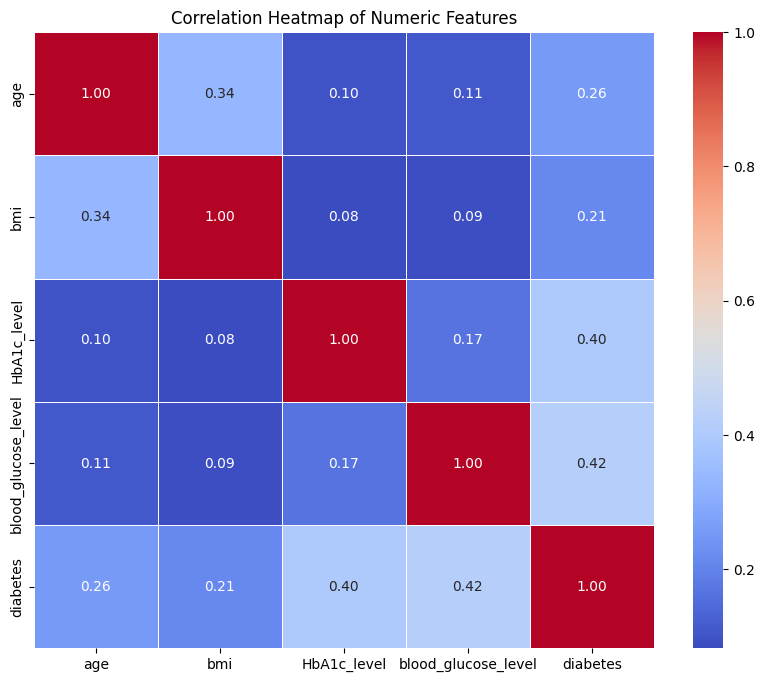

In [5]:
import seaborn as sns
numeric_columns = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','diabetes']

correlation_matrix = data[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [6]:
(
    data.corr(numeric_only=True)
            .loc[:, "diabetes"]
            .sort_values(ascending=False)
)

diabetes               1.000000
blood_glucose_level    0.420309
HbA1c_level            0.399797
age                    0.257640
bmi                    0.214557
hypertension           0.198344
heart_disease          0.172064
Name: diabetes, dtype: float64

In [ ]:
TEST_SIZE = 2e-1

# split the dataset into training and testing data
_random_state = np.random.RandomState(42)
train_features, test_features, train_target, test_target = model_selection.train_test_split(
    data.drop(['diabetes'],axis=1),
    data['diabetes'],
    test_size=TEST_SIZE,
    stratify=data['diabetes'],
    random_state=_random_state
)

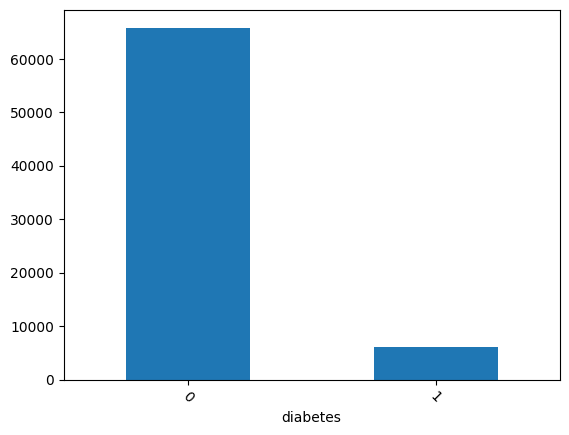

In [8]:
_ = (train_target.value_counts()
           .sort_index()
           .plot(kind="bar"))
_ = plt.xticks(rotation=-45)

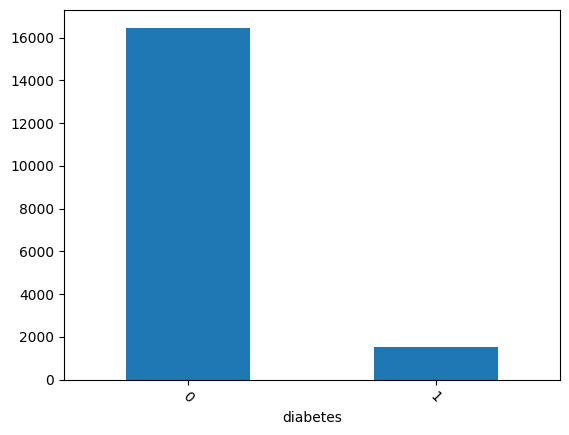

In [9]:
_ = (test_target.value_counts()
           .sort_index()
           .plot(kind="bar"))
_ = plt.xticks(rotation=-45)

In [ ]:

def column_ratio(df):
    return df.iloc[:, 0] / df.iloc[:, 1]

def column_product(df):
    return df.iloc[:, 0] * df.iloc[:, 1]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  

def product_name(function_transformer, feature_names_in):
    return ["product"]  

def bin_age(X):
    bins = [0, 18, 30, 50, 65, 80, np.inf]
    labels = [1, 2, 3, 4, 5, 6]
    return np.digitize(X, bins=bins, right=True)


def make_ratio_pipeline():
    ratio_pipeline = (
        pipeline.make_pipeline(
            impute.SimpleImputer(strategy="median"),
            preprocessing.FunctionTransformer(column_ratio, feature_names_out=ratio_name),
            preprocessing.StandardScaler(),
            verbose=True
        ).set_output(
            transform="pandas"
        )
    )
    return ratio_pipeline

def make_product_pipeline():
    product_pipeline = (
        pipeline.make_pipeline(
            impute.SimpleImputer(strategy="median"),
            preprocessing.FunctionTransformer(column_product, feature_names_out=product_name),
            preprocessing.StandardScaler(),
            verbose=True
        ).set_output(
            transform="pandas"
        )
    )
    return product_pipeline


log_transform_pipeline = (
    pipeline.make_pipeline(
        impute.SimpleImputer(strategy="median"),
        preprocessing.FunctionTransformer(np.log, np.exp, feature_names_out="one-to-one"),
        preprocessing.StandardScaler()
    ).set_output(
        transform="pandas"
    )
)


categorical_pipeline = (
    pipeline.make_pipeline(
        impute.SimpleImputer(strategy="most_frequent"),
        preprocessing.OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
    ).set_output(
        transform="pandas"
    )
)

numeric_pipeline = (
    pipeline.make_pipeline(
        impute.SimpleImputer(strategy="median"),
        preprocessing.StandardScaler(),
        verbose=True
    ).set_output(
        transform="pandas"
    )
)

VT_pipeline = (
    pipeline.make_pipeline(
        
        feature_selection.VarianceThreshold(threshold=0.0),
        verbose=True
    ).set_output(
        transform="pandas"
    )
)


binning_pipeline = (
    pipeline.make_pipeline(
        impute.SimpleImputer(strategy="most_frequent"),
        preprocessing.FunctionTransformer(func=bin_age, validate=False, feature_names_out='one-to-one'),
    ).set_output(
        transform="pandas"
    )
)



preprocessing_pipeline = (
    compose.ColumnTransformer(
        [
            ("age_bmi", make_product_pipeline(), ["age", "bmi"]),
            ("categorical", categorical_pipeline, ['blood_glucose_level','gender','hypertension','HbA1c_level','age']),
    
        ],
        n_jobs=-1,
        remainder='drop',
        verbose=True
    ).set_output(
        transform="pandas"
    )
)


In [11]:
prepared_features = preprocessing_pipeline.fit_transform(train_features)
prepared_features

,age_bmi__product,categorical__blood_glucose_level_80,categorical__blood_glucose_level_85,categorical__blood_glucose_level_90,categorical__blood_glucose_level_100,categorical__blood_glucose_level_126,categorical__blood_glucose_level_130,categorical__blood_glucose_level_140,categorical__blood_glucose_level_145,categorical__blood_glucose_level_155,...,categorical__age_71.0,categorical__age_72.0,categorical__age_73.0,categorical__age_74.0,categorical__age_75.0,categorical__age_76.0,categorical__age_77.0,categorical__age_78.0,categorical__age_79.0,categorical__age_80.0
6809,-1.105651,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55379,2.710220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54164,0.237578,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5656,-0.107391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36646,0.658365,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64948,1.717880,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74057,-0.885942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10806,-0.254088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68265,0.122589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model =  linear_model.LogisticRegression(solver='liblinear', max_iter=2000, C=10, penalty='l1')
scores = cross_val_score(
    model,
    preprocessing_pipeline.fit_transform(data.drop(['diabetes'], axis=1)),
    data['diabetes'],
    scoring=make_scorer(brier_score_loss, greater_is_better=False), 
    cv=cv, n_jobs=-1)


# report performance
print('Score: %.3f (%.3f)' % (mean(scores**2), std(scores)))

Score: 0.001 (0.002)


In [13]:
cv_results = cross_validate(
    model,
    preprocessing_pipeline.fit_transform(data.drop(['diabetes'], axis=1)),
    data['diabetes'],
    scoring=make_scorer(brier_score_loss, greater_is_better=False), 
    cv=cv, 
    n_jobs=-1,return_estimator=True)
sorted(cv_results.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

In [14]:
cv_results['test_score']**2

array([0.00094727, 0.00073501, 0.000784  , 0.00084746, 0.0009679 ,
       0.00061946, 0.00087353, 0.00074105, 0.00071111, 0.00071111])

In [15]:
selected_estimator = cv_results['estimator'][np.argmin(cv_results['test_score'])]
selected_estimator

LogisticRegression(C=10, max_iter=2000, penalty='l1', solver='liblinear')

In [16]:
logistic_regression_pipeline = pipeline.make_pipeline(
    preprocessing_pipeline,
    selected_estimator,
)

In [17]:
logistic_regression_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('age_bmi',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function product_name at 0x7e55bb288af0>,
                                                                                       func=<function column_product at 0x7e55bb288dc0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())],
                                                           verbose=...
                                                  ['age', 'bmi']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['blood_glucose_level',
                                                   'gender', 'hypertension',
                                                   'HbA1c_level', 'age'])],
                                   verbose=True)),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=2000, penalty='l1',
                                    solver='liblinear'))])

In [18]:
_ = logistic_regression_pipeline.fit(train_features, train_target)

In [23]:
submission_test = pd.read_csv("/kaggle/input/predicting-diabetes/test.csv")
submission_test

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Male,24.0,0,0,never,22.68,6.1,85
1,Female,35.0,0,0,never,28.90,6.6,130
2,Female,36.0,0,0,current,27.99,6.2,130
3,Female,52.0,0,0,never,24.30,5.7,85
4,Female,52.0,0,0,never,23.48,5.7,140
...,...,...,...,...,...,...,...,...
9995,Female,23.0,0,0,No Info,27.32,6.0,100
9996,Female,47.0,0,0,never,20.00,5.0,158
9997,Male,47.0,0,0,former,28.49,4.8,160
9998,Female,67.0,0,1,No Info,26.95,8.8,200


In [24]:
submission_test_prediction = logistic_regression_pipeline.predict_proba(submission_test)
submission_test_prediction
new_var = logistic_regression_pipeline.predict(submission_test)

In [25]:
submissions_df = (
    pd.read_csv("/kaggle/input/predicting-diabetes/sample-submission.csv")
      .assign(diabetes=submission_test_prediction[:, 1])
)

In [26]:
submissions_df.to_csv("submission.csv", index=False)

In [27]:
%%bash

cat submission.csv | head -n 5

id,diabetes
0,4.111132967989877e-06
1,0.03487139684204227
2,0.021559657420007473
3,2.309377760589179e-05


In [ ]:
import numpy as np

unique_values, counts = np.unique(new_var, return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))
for value, count in value_counts_dict.items():
    print(f"{value}: {count} times")

0: 9396 times
1: 604 times
